# Stock Forecasting Using RNNs

Final project - DATSCI 207  
Spring 2024

Daniel Florencio   
David Ilitzky  
Tahlee Stone  

## Motivation

Interest in stock market participation has surged in recent years with both retail and institutional investors seeking higher risk-adjusted returns than the market. This has been in line with record, inflation-adjusted highs observed in the US S&P 500 in 2022/24.

Accurately predicting market behaviour could therefore provide a competitive edge, inform investment decisions and risk management strategies. This prompts appetite for examining machine learning techniques for stock price prediction.


This project aims to leverage recurrent neural networks (RNNs), specifically LSTM and GRU frameworks, to develop a model for stock price predictions.  Historical stock price data will be collected, preprocessed and used to train and evaluate LSTM and RNN models, with experiments conducted on different model assumptions and hyperparameters along the way.

LSTM and GRU models were selected as they are commonly used in the stock price prediction literature for their ability to handle recurrent time series data (sequential data with long-term dependencies over time) and because they address the Vanishing Gradient Problem (VGP) that is an issue for standard RNN models.

Previous studies have explored traditional (fundamental and technical analysis) and machine-learning based approaches for stock market prediction, with mixed success. Stock market prediction is recognized as one of the most relevant, but highly challenging tasks in financial research.

The efficient market hypothesis (EMH) makes this a contentious space. The EMH states that price already reflects all available information and the best forecast of stock price is a random walk model (previous day's price plus noise). Over time, there has been challenges to the EMH (e.g. behavioural biases (speculative trading) and information asymmetry (insiders trading on privileged information)), but as a base case we will consider if our modelling techniques perform at least as well as a proxy for a random walk model.

The sections below provide detail on each component of our analysis.


## Data

Historical stock price data are obtained from the Yahoo! Finance API.  Analysis uses Microsoft Corporation (MSFT) daily closing prices using ten years’ of data (01 Mar 2014 to 31 Mar 2024).

Yahoo! Finance API provides historic data for stocks, EFTs and market indices globally. Our analysis was restricted to one stock for model development in the first instance, but can easily be extended to include other stocks in the sample later.  

The train-dev split was selected to be 70%/30%. This ensured that the training set includes sufficient time periods in the sample, out to approximately the end of 2020, which covers both upswings and downswings in the market.
Remaining data was used to create validation and test samples.


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import GRU, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

In [61]:
import yfinance as yf

ticker_symbol = 'MSFT'

start_date = '2014-03-01'
end_date = '2024-03-31'

df = yf.download(ticker_symbol, start=start_date, end=end_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-03-03,37.919998,38.130001,37.490002,37.779999,31.992281,29717500
2014-03-04,38.200001,38.480000,38.070000,38.410000,32.525776,26802400
2014-03-05,38.250000,38.270000,37.930000,38.110001,32.271736,20520100
2014-03-06,38.139999,38.240002,37.889999,38.150002,32.305607,23582200
2014-03-07,38.279999,38.360001,37.689999,37.900002,32.093899,26591600
...,...,...,...,...,...,...
2024-03-22,429.700012,429.859985,426.070007,428.739990,428.739990,17636500
2024-03-25,425.239990,427.410004,421.609985,422.859985,422.859985,18060500
2024-03-26,425.609985,425.989990,421.350006,421.649994,421.649994,16725600


This dataset has the following columns:ate.


- Open: The price at which a stock starts trading for the day.  
- High: The highest price at which a stock traded on a particular date.

- Low: The lowest price at which a stock traded on a particular date.

- Close: The price at which a stock ended trading for the day.

- Adj Close: The closing price of a stock adjusted for any corporate actions such as stock splits or dividends for a particular date.

- Volume: The total number of shares of a stock that were traded on a particular date.

Lets confirm if the obtained data is between the defined dates

In [62]:
first_index = df.index[0]
last_index = df.index[-1]

diff = last_index - first_index
print("First index:", first_index)
print("Last index:", last_index)
print(diff)

First index: 2014-03-03 00:00:00
Last index: 2024-03-28 00:00:00
3678 days 00:00:00


Check for null values

In [63]:
null_counts = df.isnull().sum()
null_counts

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Lets verify the main statistics such as count, mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile or Q2), 75th percentile (Q3)

In [64]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2.537000e+03
mean,157.710304,159.257418,156.115577,157.769496,152.521533,2.981289e+07
std,107.432524,108.483372,106.334875,107.470514,108.417195,1.375364e+07
min,37.650002,38.009998,37.490002,37.700001,31.924540,7.425600e+06
25%,57.500000,57.770000,57.200001,57.459999,52.015675,2.151220e+07
50%,115.419998,117.250000,114.930000,115.910004,110.333817,2.662630e+07
75%,249.960007,252.080002,247.169998,250.199997,245.860992,3.382910e+07
max,429.829987,430.820007,427.160004,429.369995,429.369995,2.025224e+08


Correlations

Lets check the correlations between the feautures.  
We can see below that the correlation for all columns are very positive and close to 1.  
Only for "volume" we can see a very small negative correlation.

In [65]:
correlation_matrix = df.corr()
correlation_matrix

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999875,0.999864,0.999706,0.999638,-0.098166
High,0.999875,1.000000,0.999822,0.999853,0.999782,-0.093510
Low,0.999864,0.999822,1.000000,0.999869,0.999805,-0.103660
Close,0.999706,0.999853,0.999869,1.000000,0.999928,-0.099213
Adj Close,0.999638,0.999782,0.999805,0.999928,1.000000,-0.099701
Volume,-0.098166,-0.093510,-0.103660,-0.099213,-0.099701,1.000000


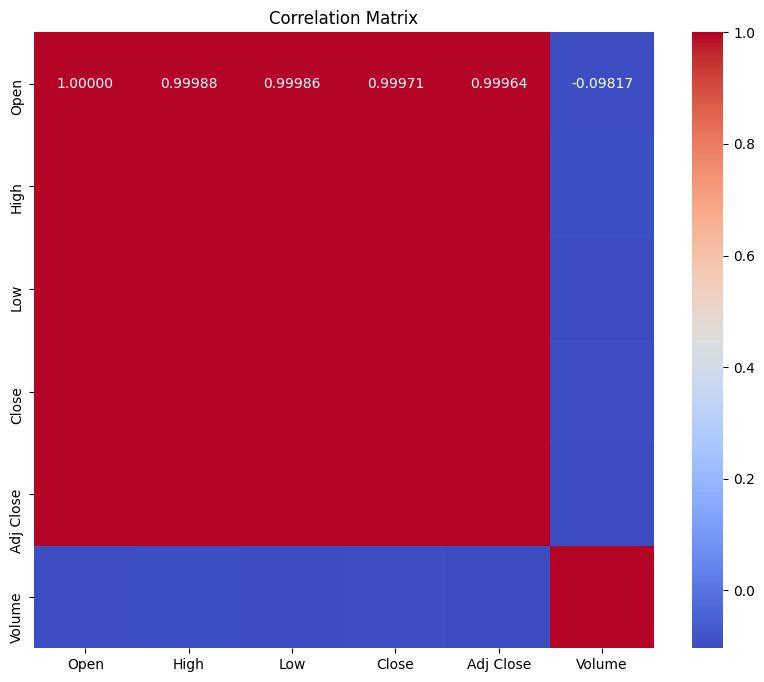

In [66]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".5f")
plt.title('Correlation Matrix')
plt.show()

Lets evaluate how prices correlate through time.  

The correlation matrix shows the correlation between the `Close` prices of a stock on the current day and its `Close` prices for previous days (1, 2, 3, 4, 5, 10, 20, and 30 days earlier).  
we can note that the correlation coefficient decreases as the gap between the days increases. That is the expected behaviour.

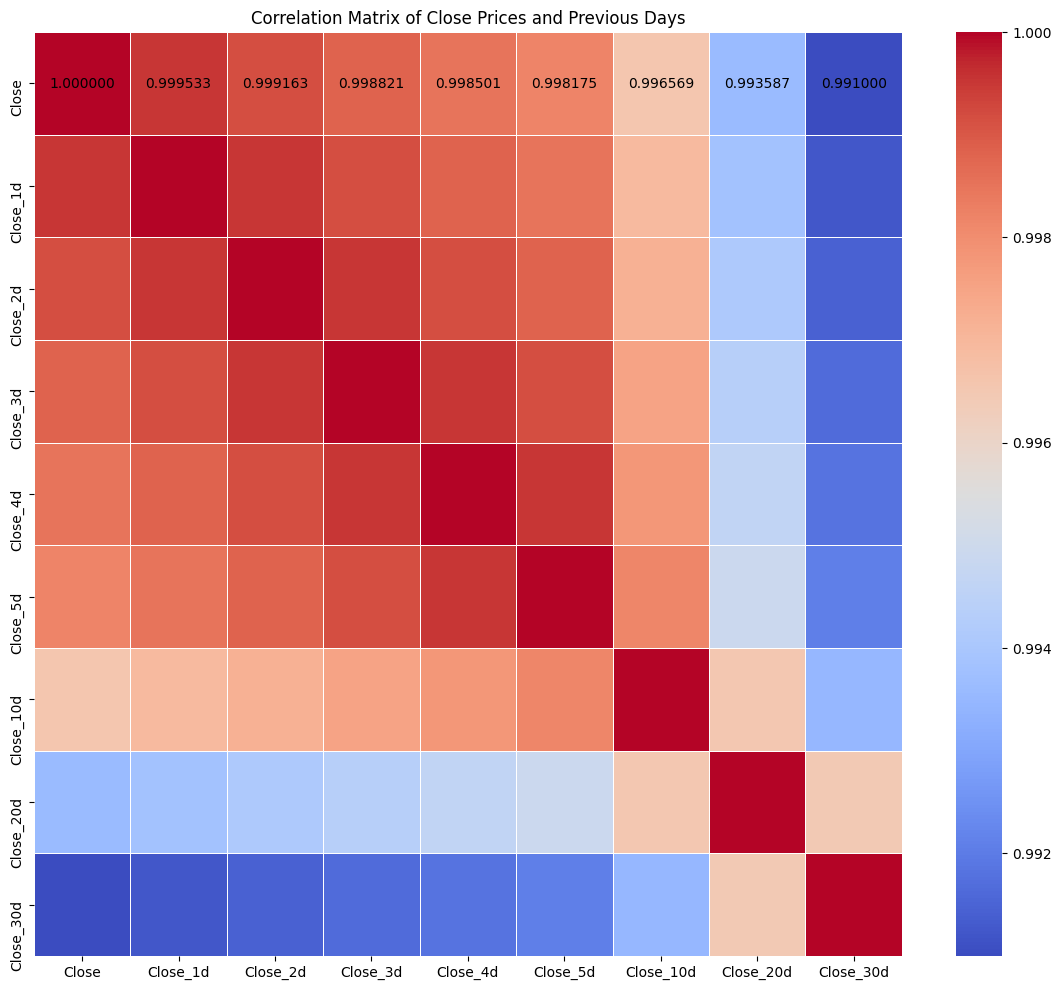

In [67]:
for days in [1, 2, 3, 4, 5, 10, 20, 30]:
    df[f'Close_{days}d'] = df['Close'].shift(days)

# List of columns to include
columns_close_days_extended = ['Close'] + [f'Close_{i}d' for i in [1, 2, 3, 4, 5, 10, 20, 30]]

close_days_data_extended = df[columns_close_days_extended].dropna()

# Calculate the correlation matrix
correlation_matrix_close_days_extended = close_days_data_extended.corr()

# Plot
plt.figure(figsize=(14, 12))  # Increase figure size
ax = sns.heatmap(correlation_matrix_close_days_extended, annot=True, cmap='coolwarm', fmt=".6f",
                 linewidths=.5, annot_kws={'size': 10, 'color': 'black'})
plt.title('Correlation Matrix of Close Prices and Previous Days')
plt.show()

We can conclude that the most relevant features are the days close to the desired date.  
That will lead us tu only use the past `close` prices and discard the other feautures for a simpler model.

Check differences on price. High - low, open -close, etc

In [68]:
df['open-close'] = df['Open'] - df['Close']

Count positive and negative values in "open-close"

In [69]:
positive_count = (df['open-close'] > 0).sum()
negative_count = (df['open-close'] < 0).sum()

counts_df = pd.DataFrame({'Count': [positive_count, negative_count]}, index=['Positive', 'Negative'])
counts_df

,Count
Positive,1181
Negative,1339


we can see that a very similar count for positive and negative intraday price variation.  
This is expected for this kind of data.

Conclusion

For our models we are only interested in the closing price for each date, so we define the `close_prices` dataframe

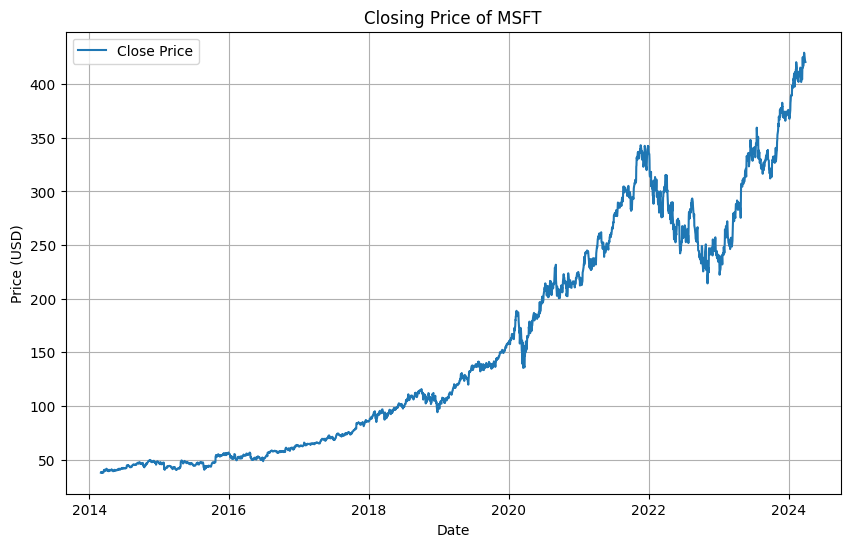

In [70]:
close_prices = df['Close']

plt.figure(figsize=(10, 6))
plt.plot(close_prices, label='Close Price')
plt.title(f'Closing Price of {ticker_symbol}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


---
## Modeling

#### Train, Validation and Test Split

Lets define our split precentages

In [71]:
train_percent = 0.7
val_percent = 0.15

In [72]:
train_size = int(len(close_prices) * train_percent)
validation_size = int(len(close_prices) * val_percent)
test_size = len(close_prices) - train_size - validation_size

train_data = close_prices[:train_size]
validation_data = close_prices[train_size:train_size + validation_size]
test_data = close_prices[train_size + validation_size:]

Lets visualize the splitted data

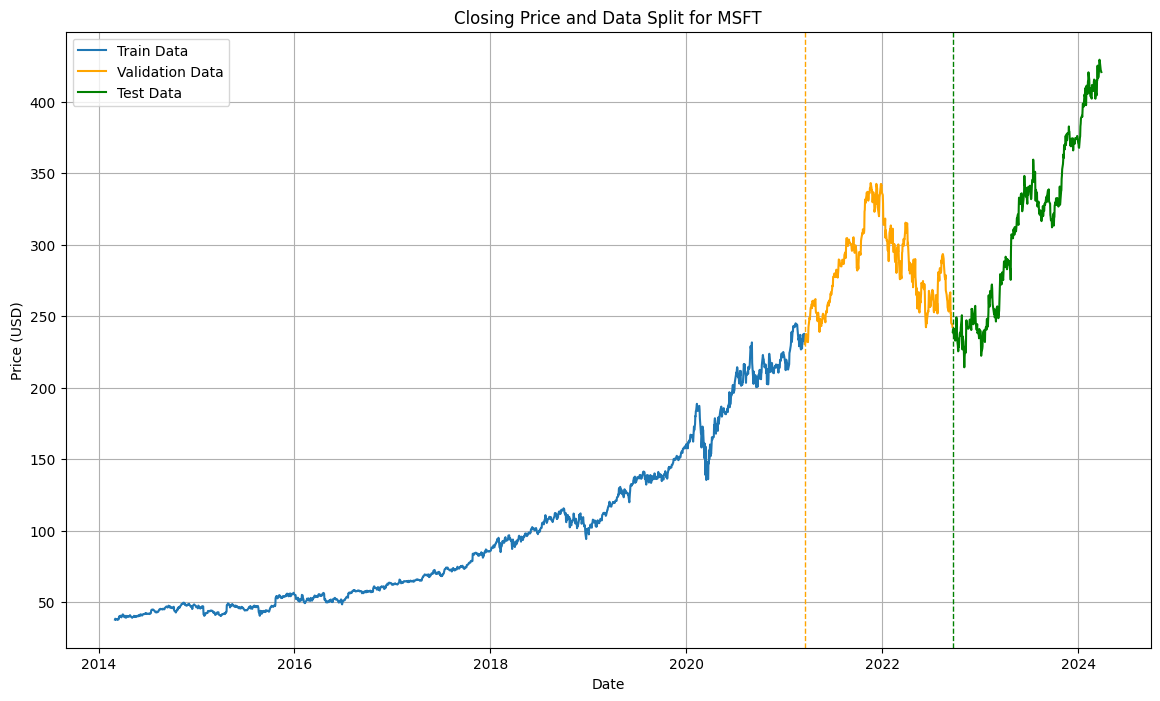

In [73]:
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data, label='Train Data')
plt.plot(validation_data.index, validation_data, label='Validation Data', color='orange')
plt.plot(test_data.index, test_data, label='Test Data', color='green')

plt.axvline(close_prices.index[train_size], color='orange', linestyle='--', linewidth=1)
plt.axvline(close_prices.index[train_size + validation_size], color='green', linestyle='--', linewidth=1)

plt.title(f'Closing Price and Data Split for {ticker_symbol}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### Data Preparation

Lets define a `Scaler` to scale the input data to a specified range: between 0 and 1.  
Then we can create the `scaled_data` for future tasks.

In [74]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.values.reshape(-1, 1))

Lets create a function `create_sequences`:  
This function creates sequences of input-output pairs from the time series data. It takes the scaled data and a parameter sequence_length, which determines the length of each input sequence. It then creates input sequences (xs) and corresponding output values (ys). Each x is a sequence of sequence_length consecutive data points, and the corresponding y is the data point immediately following the sequence.

In [75]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data)-sequence_length):
        x = data[i:(i+sequence_length)]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

Define `sequence_length` and create X, y

In [76]:
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

Train, Validation and Test Split on `X, y`

In [77]:
X_train = X[:train_size]
X_val = X[train_size:train_size + validation_size]
X_test = X[train_size + validation_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size + validation_size]
y_test = y[train_size + validation_size:]


#### Baseline Model

We defined very simple baseline model before employing machine learning techniques, a persistence model.  
The persistence model simply predicts the next value in the sequence to be the same as the last value observed.

In [78]:
def persistence_model_predict(X):
    return X[:, -1]

In [79]:
#Calculate performance metrics 
train_predictions = persistence_model_predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))
train_rmse = np.sqrt(mean_squared_error(actual_train, train_predictions))

val_predictions = persistence_model_predict(X_val)
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1))
actual_val = scaler.inverse_transform(y_val.reshape(-1, 1))
val_rmse = np.sqrt(mean_squared_error(actual_val, val_predictions))

test_predictions = persistence_model_predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_rmse = np.sqrt(mean_squared_error(actual_test, test_predictions))

#Create a dataframe
data_after = {'Set': ['Training', 'Validation', 'Test'],
        'Base': [train_rmse, val_rmse, test_rmse]}
df_results_base = pd.DataFrame(data_after)

df_results_base

,Set,Base
0,Training,2.253080
1,Validation,5.283279
2,Test,4.797130


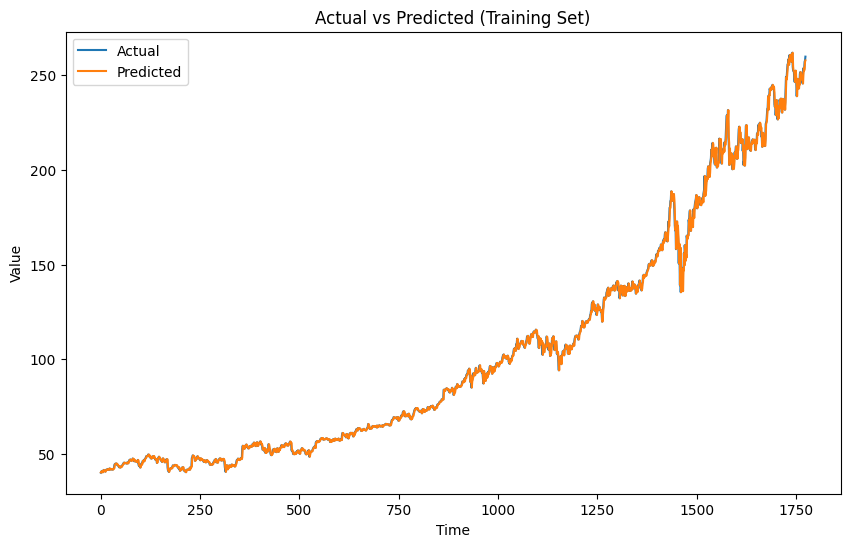

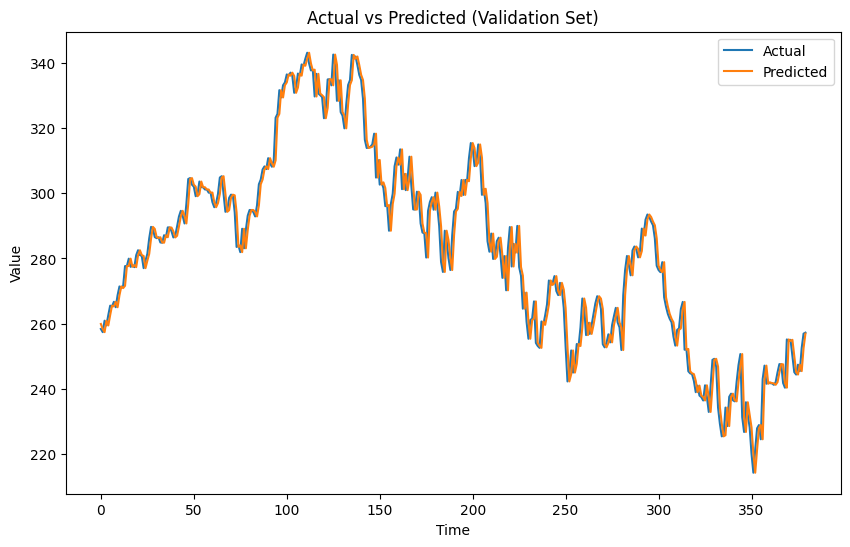

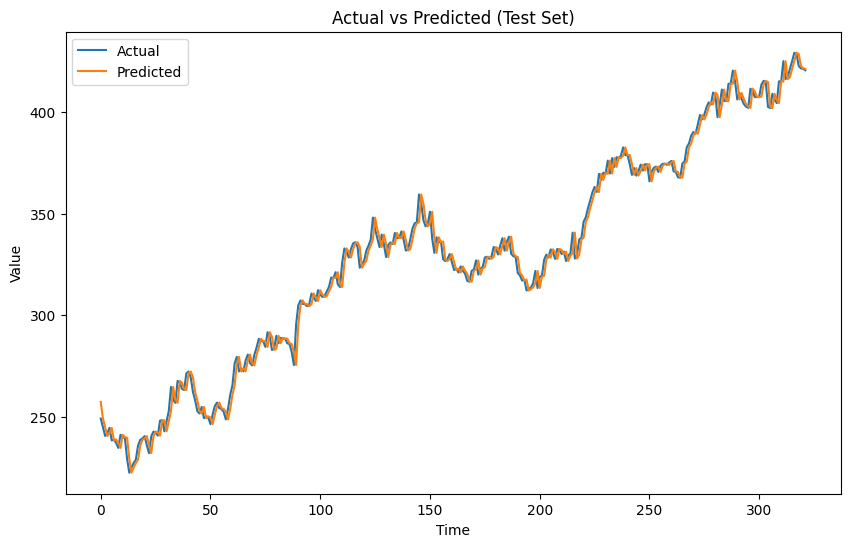

In [80]:
# Plotting function
def plot_actual_vs_predicted(actual, predicted, set_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(f'Actual vs Predicted ({set_name} Set)')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Plot actual vs predicted for training set
plot_actual_vs_predicted(actual_train, train_predictions, 'Training')

#for validation set
plot_actual_vs_predicted(actual_val, val_predictions, 'Validation')

#for test set
plot_actual_vs_predicted(actual_test, test_predictions, 'Test')


#### Functions

We will define the functions `build_model` and `train_and_evaluate` that allows for a range of experiments.

The `build_model` function builds a recurrent neural network (RNN) model, either LSTM or GRU, using Keras. It allows customization of optimizer, learning rate, batch size, sequence length, and model type. The function returns the compiled Keras model ready for training.

In [81]:
def build_model(optimizer='SGD',
                learning_rate=0.01,
                batch_size=64,
                sequence_length=60,
                model_type='LSTM'):
    """Build a LSTM or GRU model using Keras.

    Args:
        optimizer: The optimizer to use (SGD, Adam).
        learning_rate: The desired learning rate for the optimizer.
        batch_size: Batch size for training.
        sequence_length: Sequence length for the input data.
        model_type: Type of RNN model to use (LSTM or GRU).

    Returns:
        model: A tf.keras model.
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
        model.add(LSTM(50))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=True, input_shape=(sequence_length, 1)))
        model.add(GRU(50))
    else:
        raise ValueError("Unsupported RNN model type")

    model.add(Dense(25))
    model.add(Dense(1))

    # Compile model
    if optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')

    return model


The `train_and_evaluate` function trains and evaluates a recurrent neural network (RNN) model using specified hyperparameters such as optimizer, learning rate, batch size, sequence length, model type (LSTM or GRU), and number of epochs. It internally utilizes the `build_model` function to construct the RNN model.   

After training, it plots the training and validation loss curves, calculates the root mean squared error (RMSE) for the training, validation, and test datasets, and returns these RMSE values.

In [82]:
def train_and_evaluate(optimizer='SGD',
                       learning_rate=0.01,
                       batch_size=64,
                       sequence_length=60,
                       model_type='LSTM',
                       num_epochs=5):

    # Build the model.
    model = build_model(optimizer=optimizer,
                        learning_rate=learning_rate,
                        batch_size=batch_size,
                        sequence_length=sequence_length,
                        model_type=model_type)

    num_params = model.count_params()
    
    # Train the model.
    print('Training...')

    history = model.fit(x=X_train, y=y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

    # Plotting the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Predictions on the training data
    train_predictions = model.predict(X_train)
    train_predictions = scaler.inverse_transform(train_predictions)
    actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    train_rmse = np.sqrt(mean_squared_error(actual_train, train_predictions))

    # Predictions on the validation data
    val_predictions = model.predict(X_val)
    val_predictions = scaler.inverse_transform(val_predictions)
    actual_val = scaler.inverse_transform(y_val.reshape(-1, 1))
    val_rmse = np.sqrt(mean_squared_error(actual_val, val_predictions))

    # Predictions on the test data
    test_predictions = model.predict(X_test)
    test_predictions = scaler.inverse_transform(test_predictions)
    actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    test_rmse = np.sqrt(mean_squared_error(actual_test, test_predictions))

    # Plot actual vs predicted values for training data
    plt.plot(actual_train, label='Actual Train', linestyle='-')
    plt.plot(train_predictions, label='Predicted Train', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Values (Training)')
    plt.legend()
    plt.show()

    # Plot actual vs predicted values for validation data
    plt.plot(actual_val, label='Actual Validation', linestyle='-')
    plt.plot(val_predictions, label='Predicted Validation', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Values (Validation)')
    plt.legend()
    plt.show()

    # Plot actual vs predicted values for test data
    plt.plot(actual_test, label='Actual Test', linestyle='-')
    plt.plot(test_predictions, label='Predicted Test', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Values (Test)')
    plt.legend()
    plt.show()

    return num_params, train_rmse, val_rmse, test_rmse

In summary, in this section we defined the `Base Model` and the `functions` needed to run the experiments


---
### EXPERIMENTS

In the experiments conducted, various configurations of `LSTM - Long Short-Term Memory` and `GRU - Gated Recurrent Unit` models were evaluated. 

These experiments varied the `optimizer`, `batch size`, `learning rate`, and `sequence length` while measuring the model's performance based on the `training`, `validation`, and `test` root mean squared error (RSME).  

The results provide insights into which configurations perform best for predicting stock prices.  

The table below shows the `Experiment Configurations` and the results obtained.

| Model Type | Optimizer | Batch Size | Learning Rate | Sequence Length | # Parameters | Train RMSE | Validation RMSE | Test RMSE |
|------------|-----------|------------|---------------|-----------------|--------------|------------|-----------------|-----------|
| BASELINE   | -         | -          | -             | -               | -            | 2.25       | 5.28            | 4.79      |
| LSTM       | Adam      | 32         | 0.001         | 60              | 31901        | 2.31       | 5.71            | 5.90      |
| LSTM       | Adam      | 64         | 0.001         | 60              | 31901        | 2.49       | 6.48            | 6.93      |
| LSTM       | Adam      | 32         | 0.01          | 60              | 31901        | 4.43       | 5.76            | 5.38      |
| LSTM       | Adam      | 32         | 0.001         | 90              | 31901        | 3.15       | 7.34            | 5.84      |
| LSTM       | SGD       | 32         | 0.001         | 60              | 31901        | 5.05       | 14.58           | 24.93     |
| LSTM       | SGD       | 64         | 0.001         | 60              | 31901        | 20.83      | 65.50           | 92.94     |
| LSTM       | SGD       | 32         | 0.01          | 60              | 31901        | 4.44       | 15.44           | 32.35     |
| LSTM       | SGD       | 32         | 0.001         | 90              | 31901        | 5.17       | 16.15           | 35.06     |
| GRU        | Adam      | 32         | 0.001         | 60              | 24551        | 2.54       | 6.37            | 5.46      |
| GRU        | Adam      | 64         | 0.001         | 60              | 24551        | 3.68       | 7.68            | 6.68      |
| GRU        | Adam      | 32         | 0.01          | 60              | 24551        | 2.38       | 6.41            | 15.97     |
| GRU        | Adam      | 32         | 0.001         | 90              | 24551        | 2.77       | 6.35            | 5.18      |
| GRU        | SGD       | 32         | 0.001         | 60              | 24551        | 13.05      | 37.69           | 50.47     |
| GRU        | SGD       | 64         | 0.001         | 60              | 24551        | 33.68      | 98.16           | 127.05    |
| GRU        | SGD       | 32         | 0.01          | 60              | 24551        | 2.83       | 7.54            | 8.19      |
| GRU        | SGD       | 32         | 0.001         | 90              | 24551        | 4.82       | 11.82           | 17.50     |



Running experiment: Model Type - LSTM, Optimizer - Adam, Batch Size - 32, Learning Rate - 0.001, Sequence Length - 60
Training...


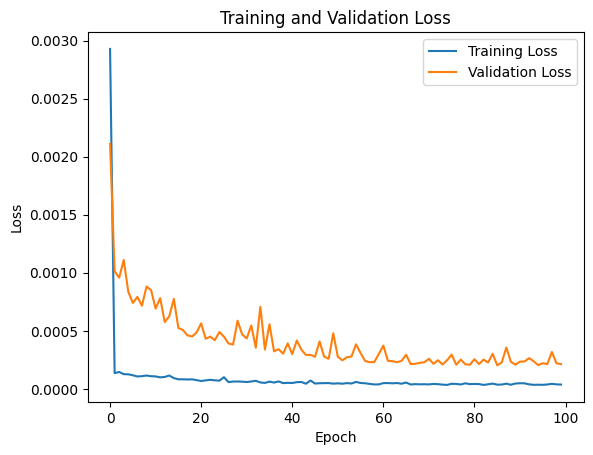

11/11 [==============================] - 0s 11ms/step


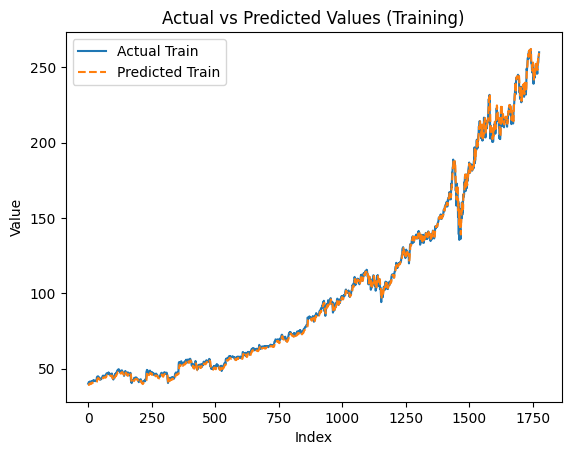

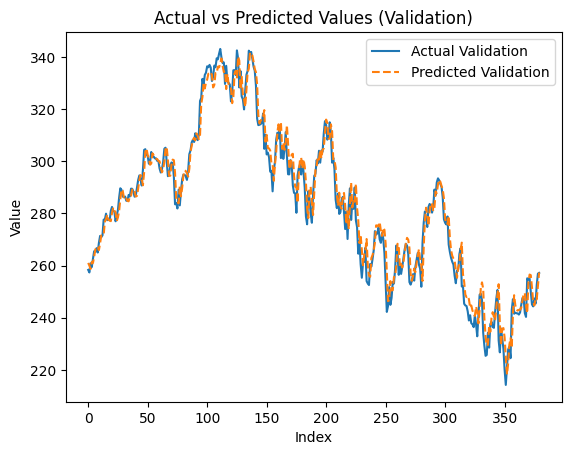

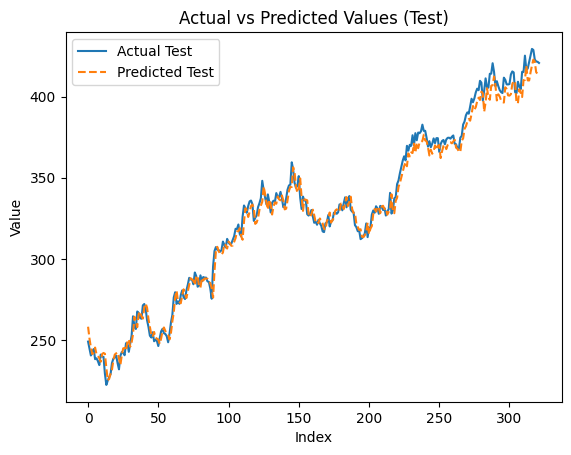

Running experiment: Model Type - LSTM, Optimizer - Adam, Batch Size - 64, Learning Rate - 0.001, Sequence Length - 60
Training...


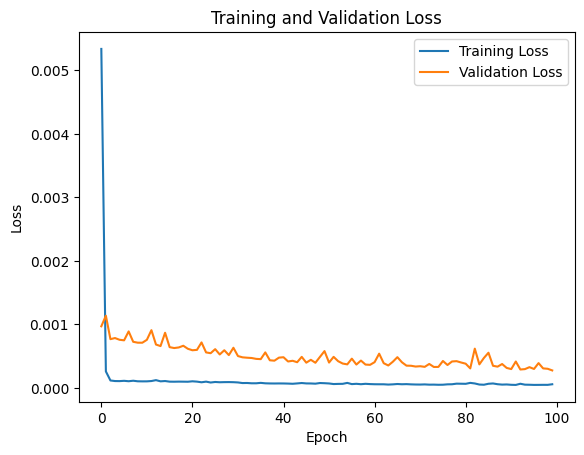

11/11 [==============================] - 0s 13ms/step


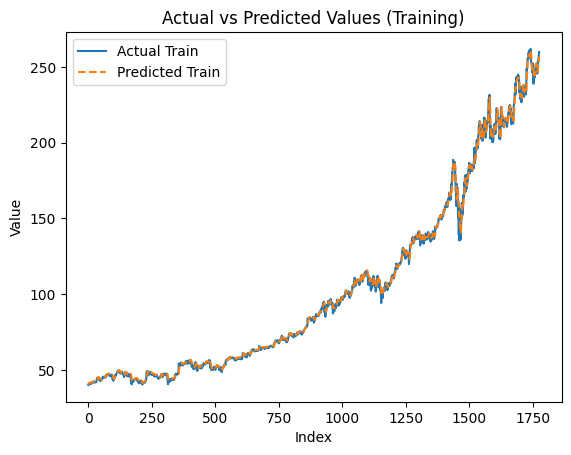

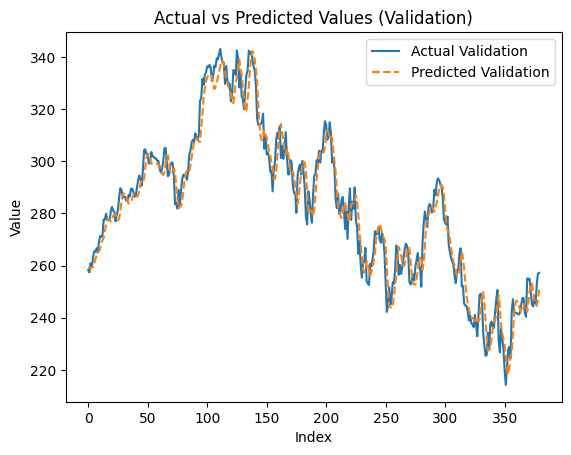

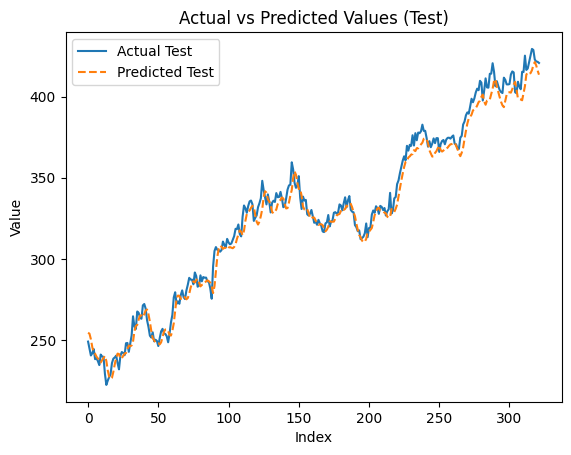

Running experiment: Model Type - LSTM, Optimizer - Adam, Batch Size - 32, Learning Rate - 0.01, Sequence Length - 60
Training...


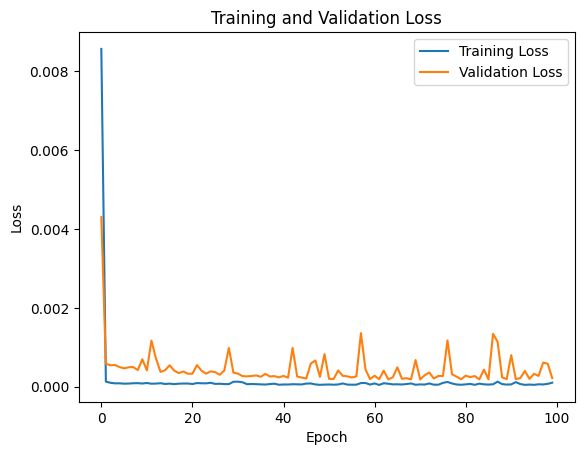

11/11 [==============================] - 0s 12ms/step


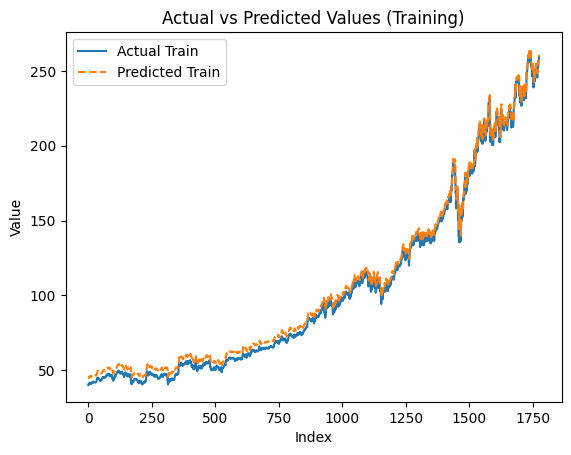

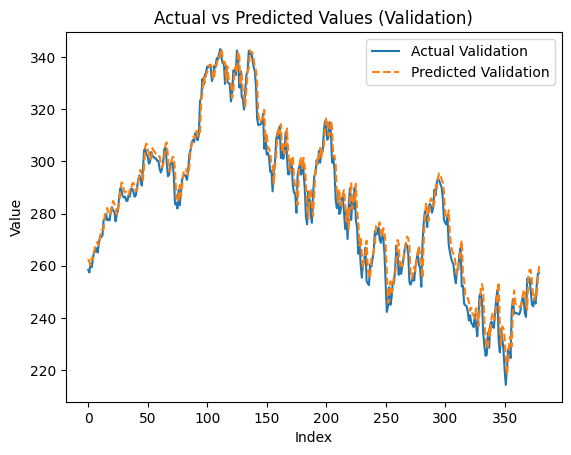

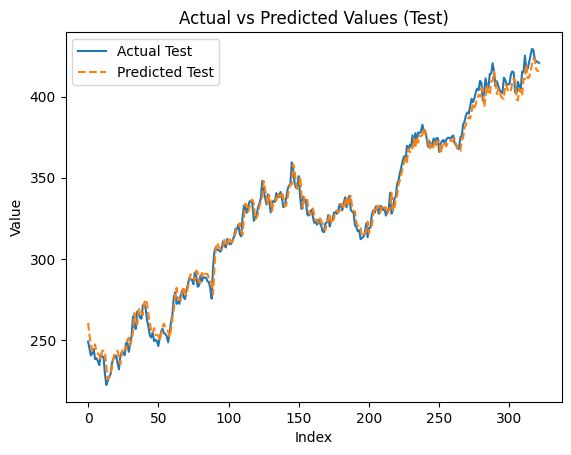

Running experiment: Model Type - LSTM, Optimizer - Adam, Batch Size - 32, Learning Rate - 0.001, Sequence Length - 90
Training...


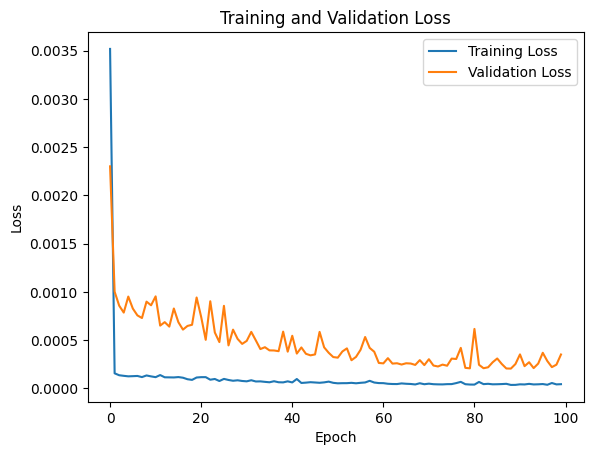

10/10 [==============================] - 0s 15ms/step


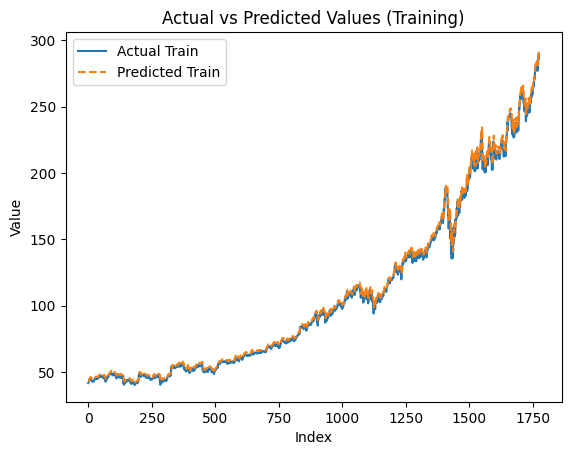

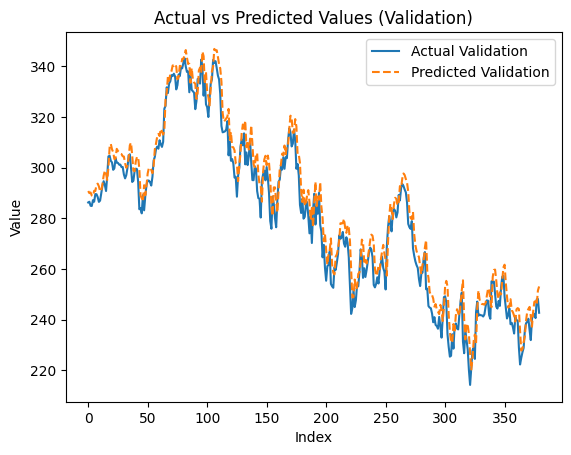

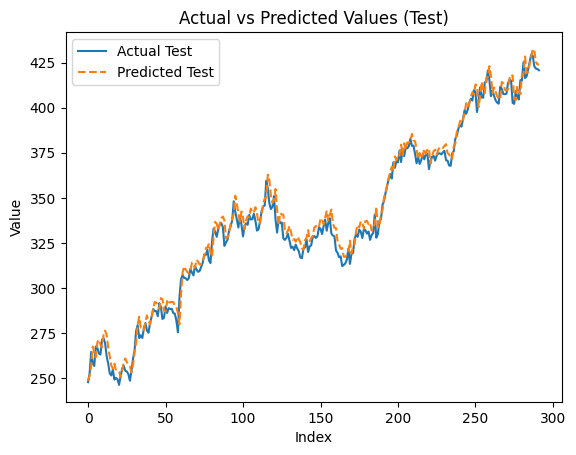

Running experiment: Model Type - LSTM, Optimizer - SGD, Batch Size - 32, Learning Rate - 0.001, Sequence Length - 60
Training...


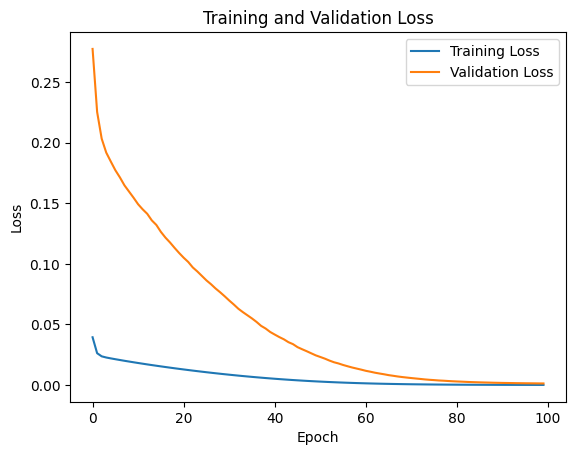

11/11 [==============================] - 0s 12ms/step


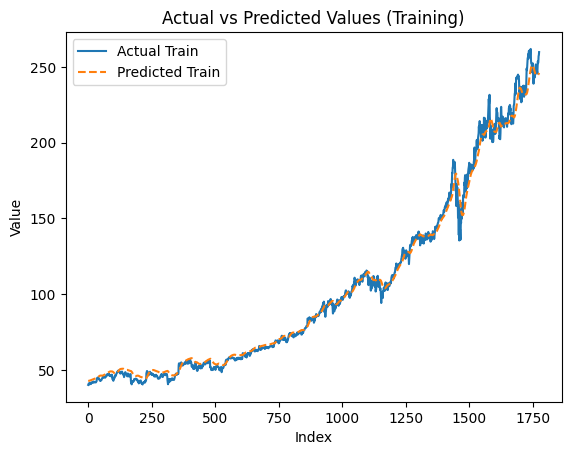

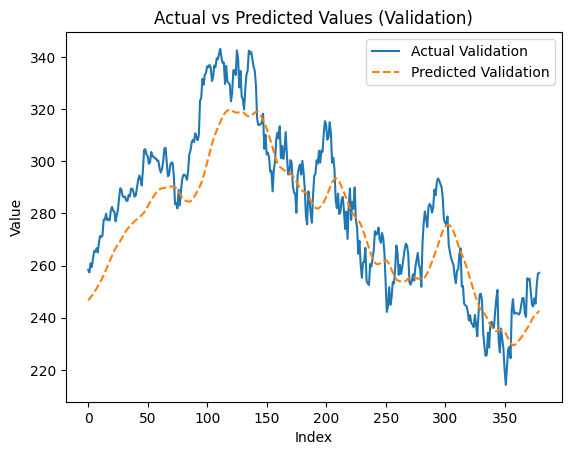

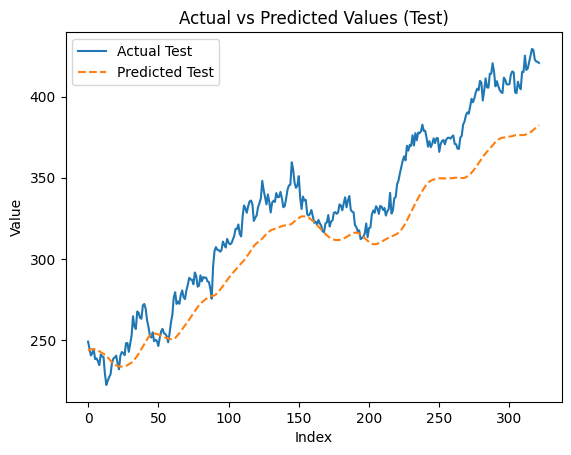

Running experiment: Model Type - LSTM, Optimizer - SGD, Batch Size - 64, Learning Rate - 0.001, Sequence Length - 60
Training...


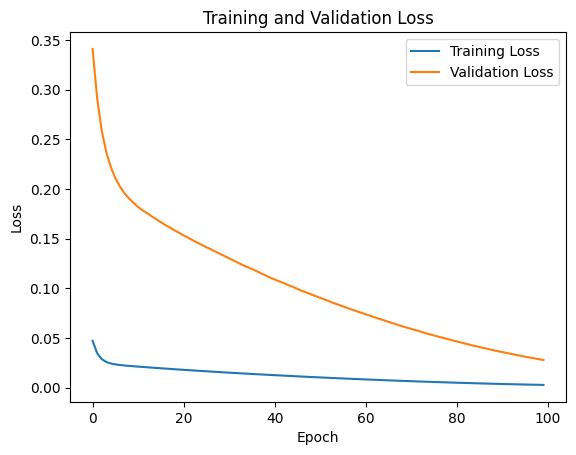

11/11 [==============================] - 0s 12ms/step


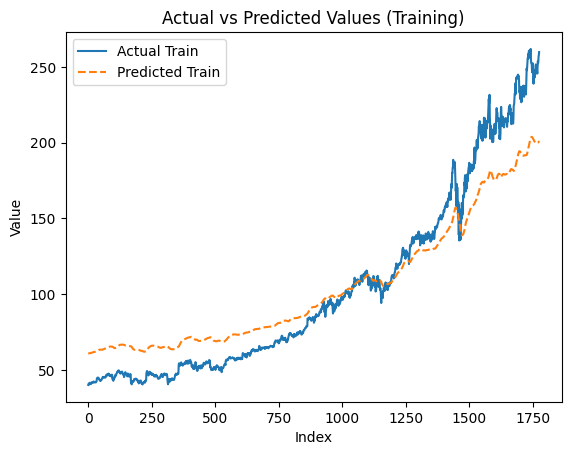

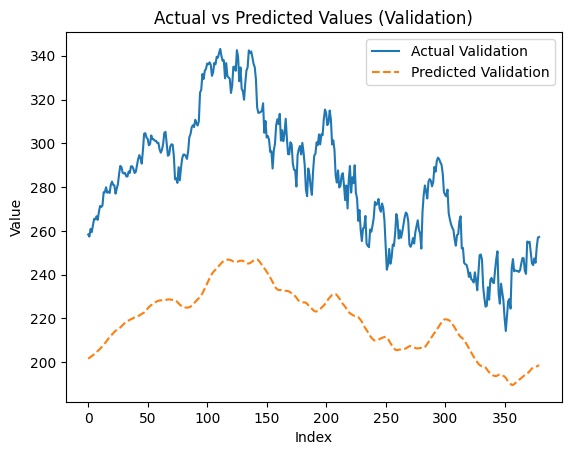

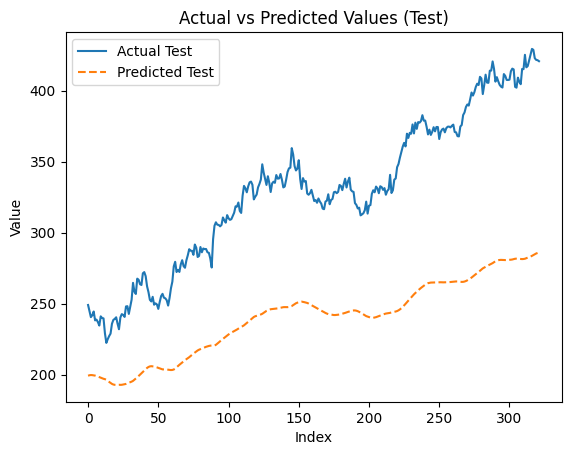

Running experiment: Model Type - LSTM, Optimizer - SGD, Batch Size - 32, Learning Rate - 0.01, Sequence Length - 60
Training...


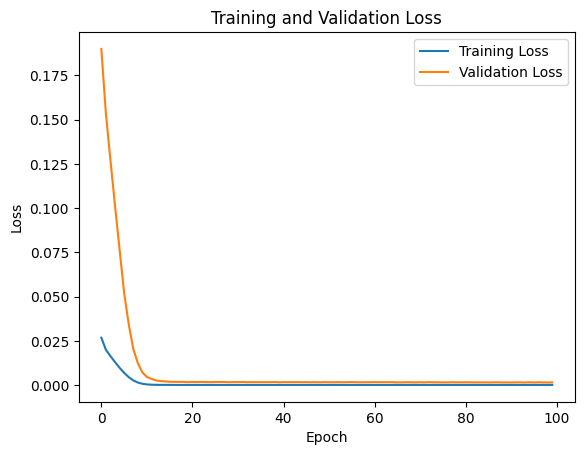

11/11 [==============================] - 0s 13ms/step


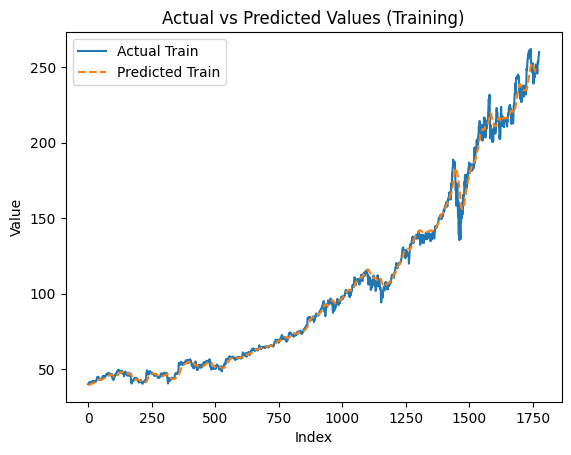

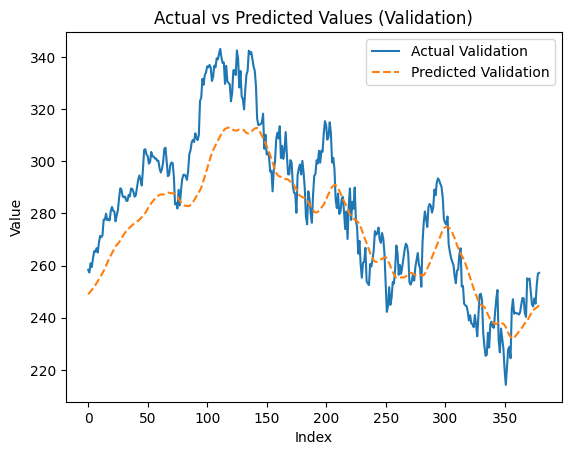

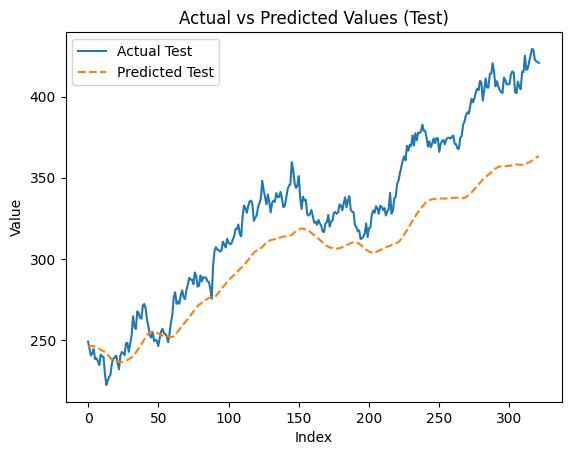

Running experiment: Model Type - LSTM, Optimizer - SGD, Batch Size - 32, Learning Rate - 0.001, Sequence Length - 90
Training...


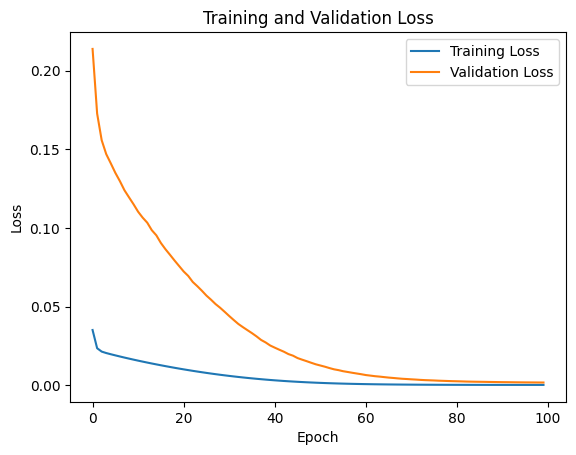

10/10 [==============================] - 0s 17ms/step


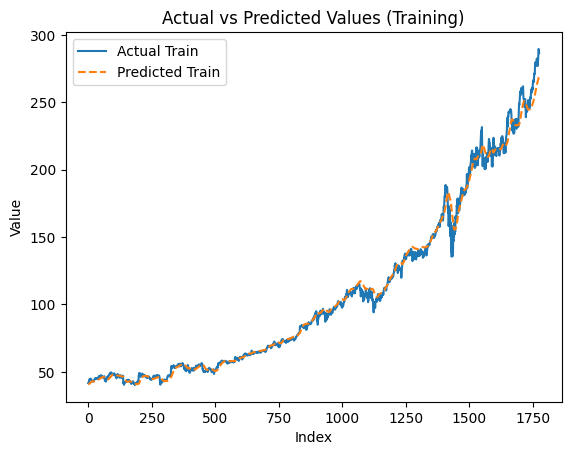

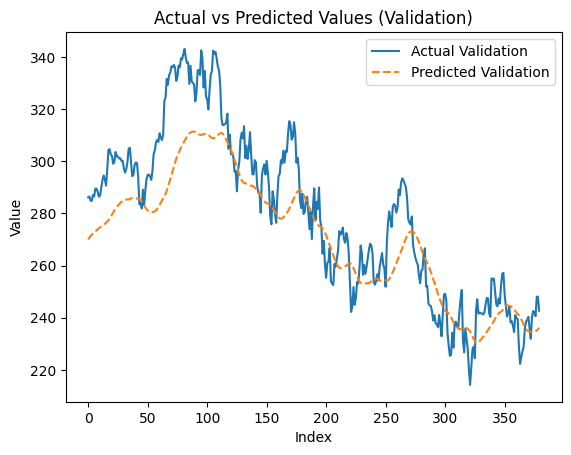

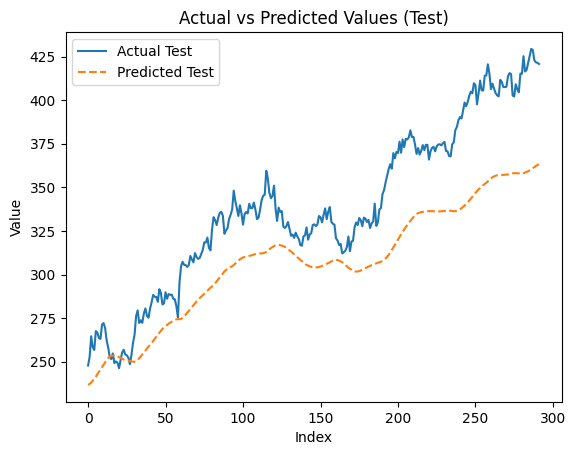

Running experiment: Model Type - GRU, Optimizer - Adam, Batch Size - 32, Learning Rate - 0.001, Sequence Length - 60
Training...


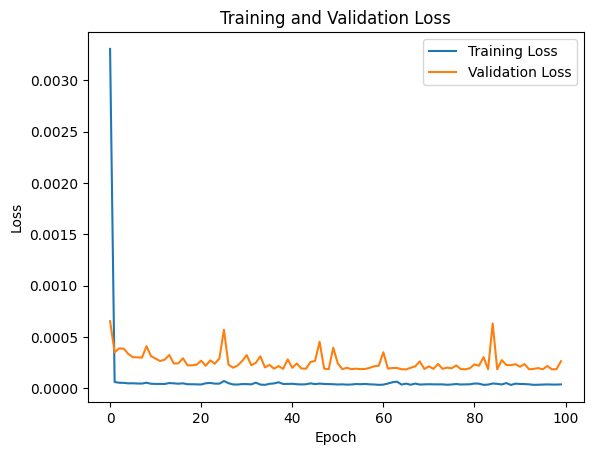

11/11 [==============================] - 0s 15ms/step


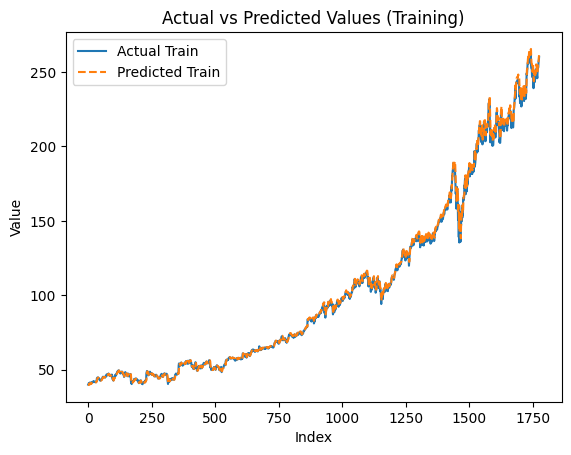

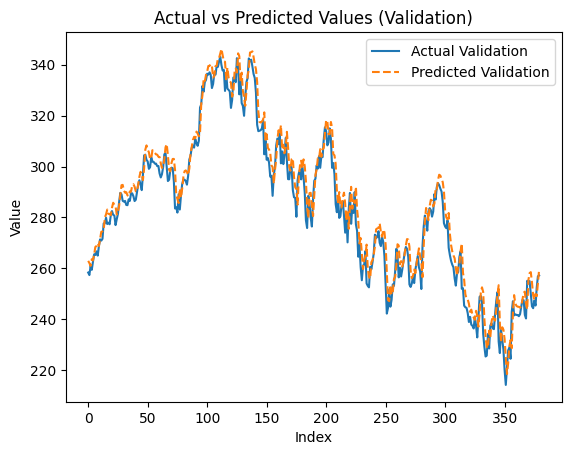

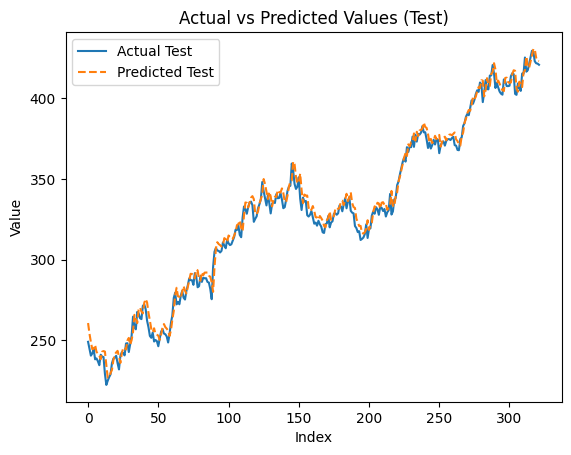

Running experiment: Model Type - GRU, Optimizer - Adam, Batch Size - 64, Learning Rate - 0.001, Sequence Length - 60
Training...


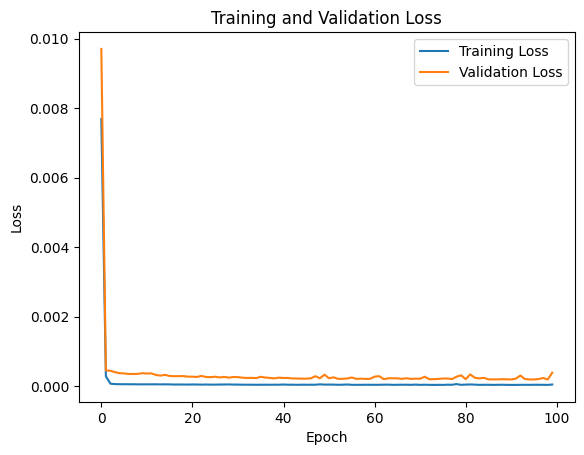

11/11 [==============================] - 0s 13ms/step


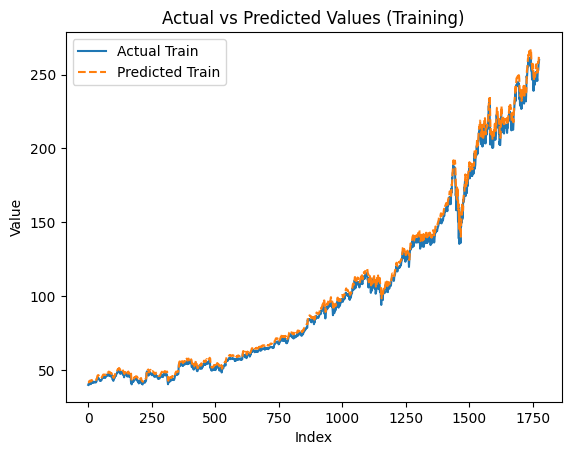

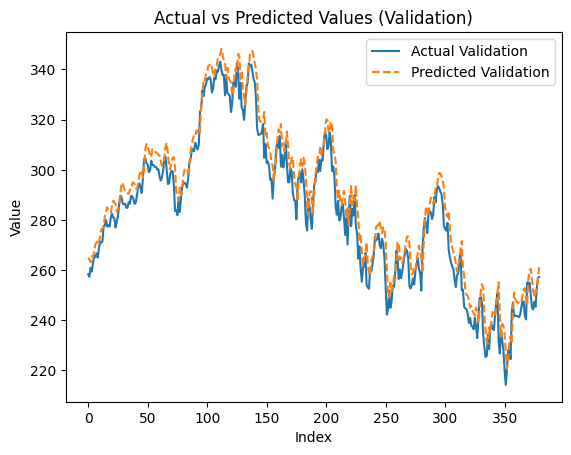

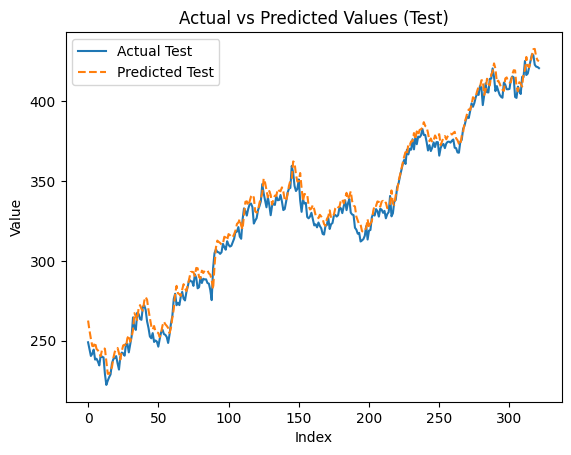

Running experiment: Model Type - GRU, Optimizer - Adam, Batch Size - 32, Learning Rate - 0.01, Sequence Length - 60
Training...


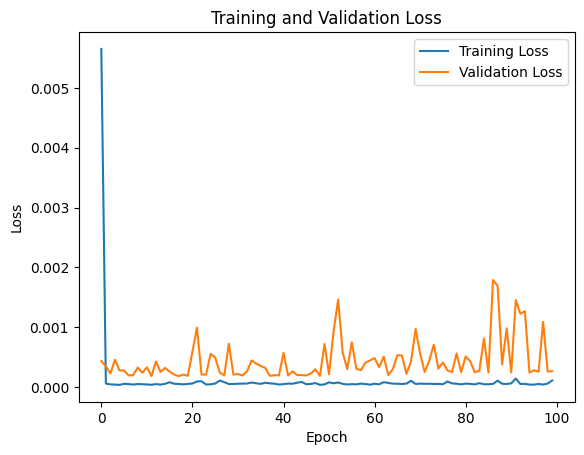

11/11 [==============================] - 0s 12ms/step


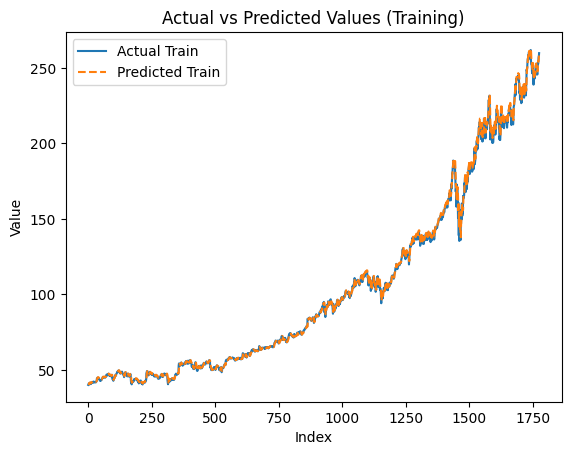

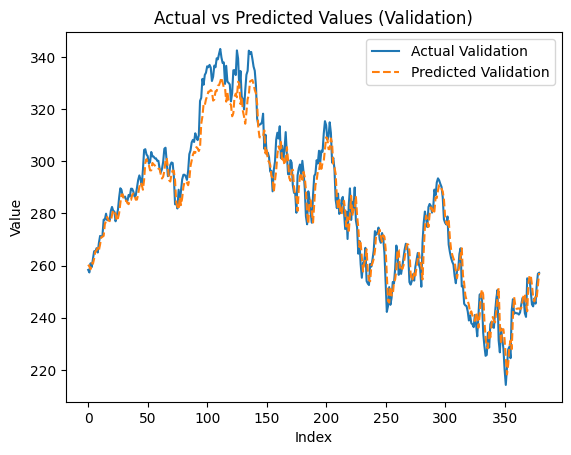

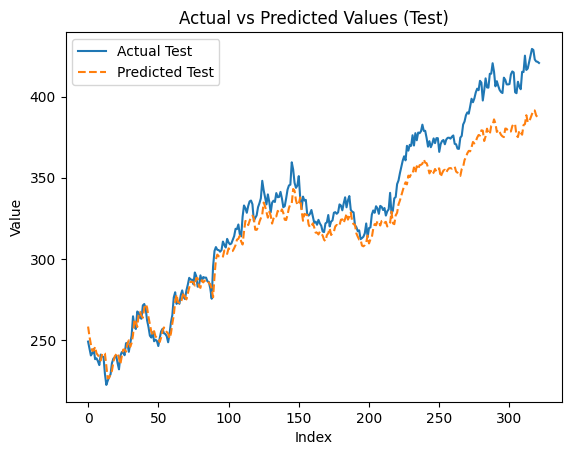

Running experiment: Model Type - GRU, Optimizer - Adam, Batch Size - 32, Learning Rate - 0.001, Sequence Length - 90
Training...


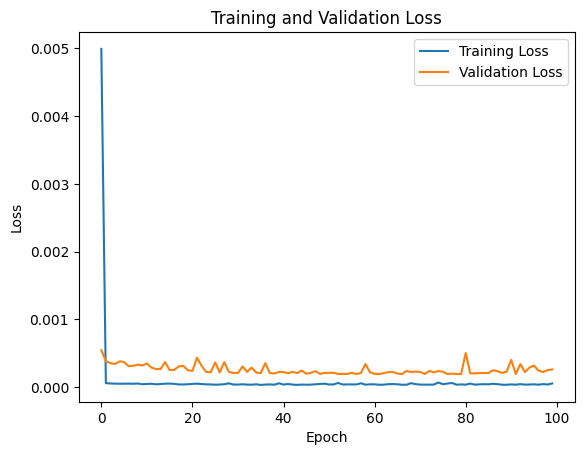

10/10 [==============================] - 0s 15ms/step


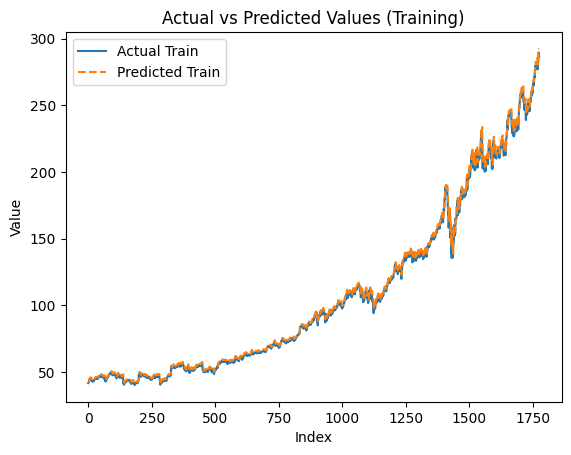

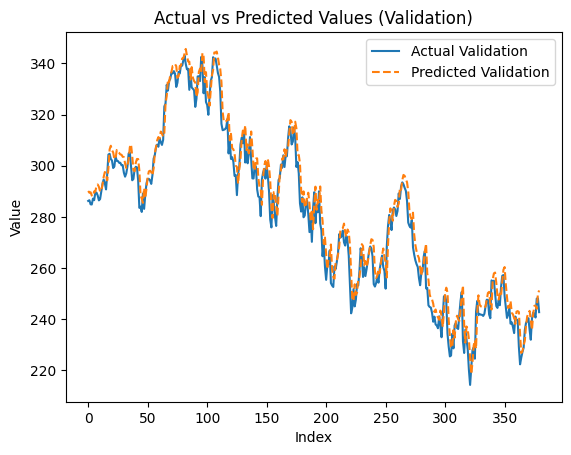

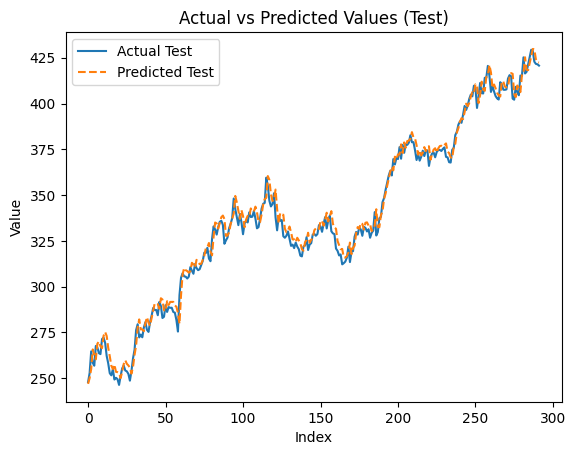

Running experiment: Model Type - GRU, Optimizer - SGD, Batch Size - 32, Learning Rate - 0.001, Sequence Length - 60
Training...


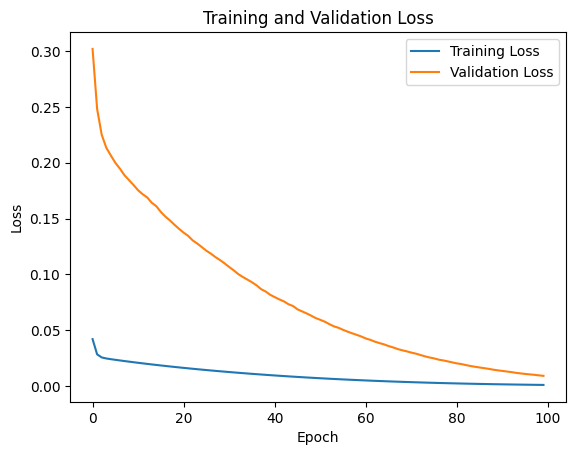

11/11 [==============================] - 0s 11ms/step


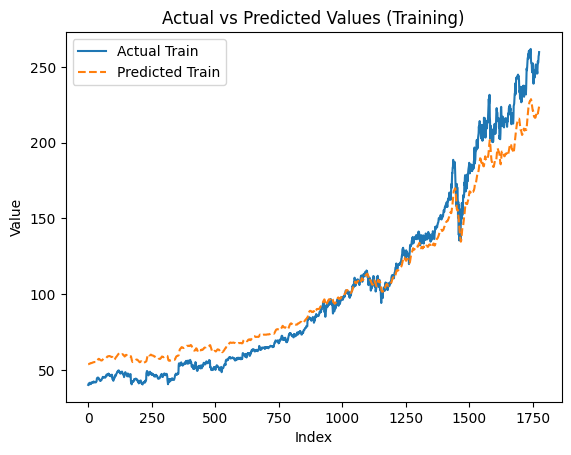

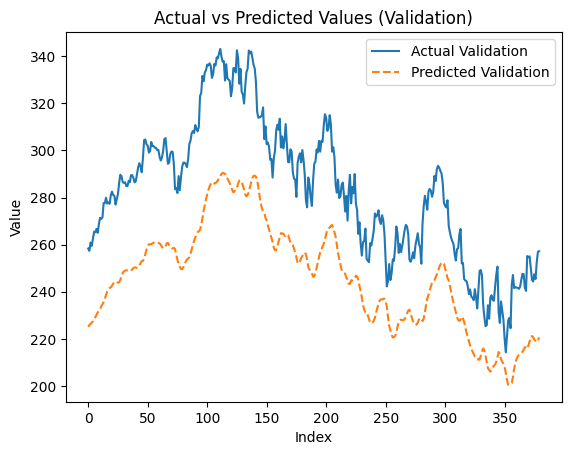

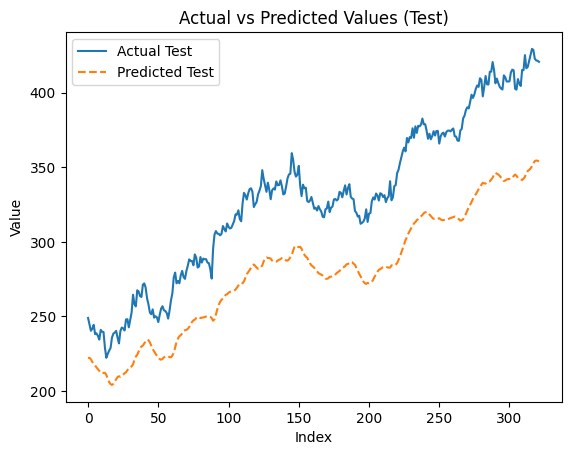

Running experiment: Model Type - GRU, Optimizer - SGD, Batch Size - 64, Learning Rate - 0.001, Sequence Length - 60
Training...


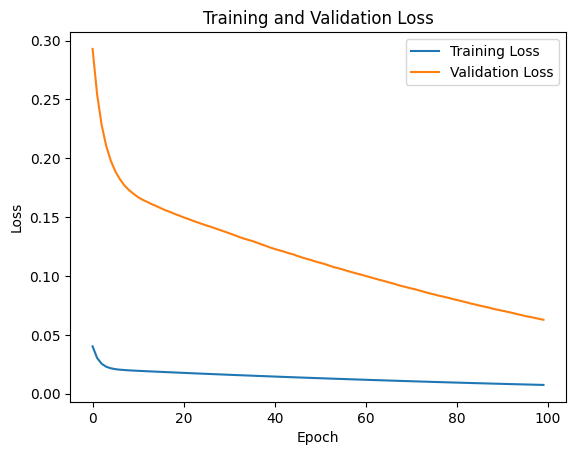

11/11 [==============================] - 0s 12ms/step


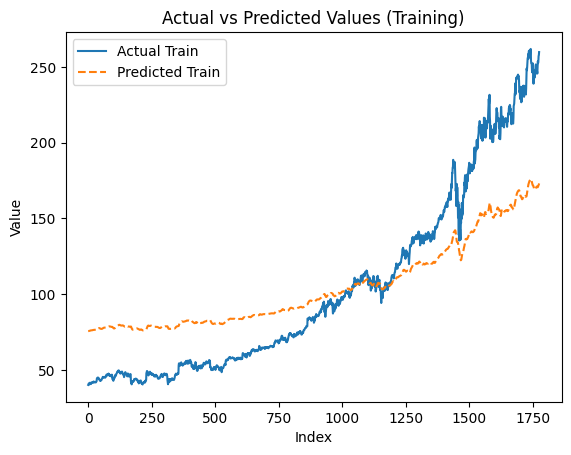

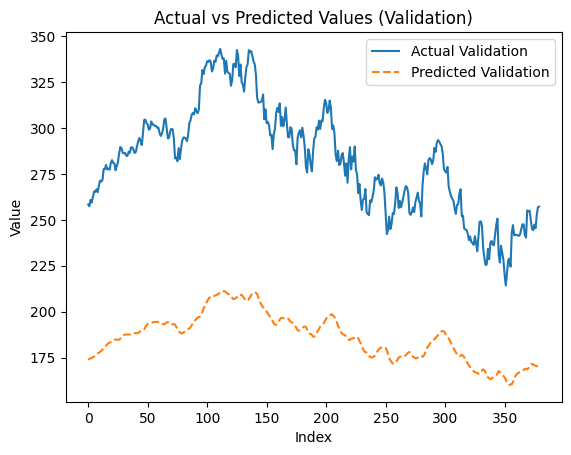

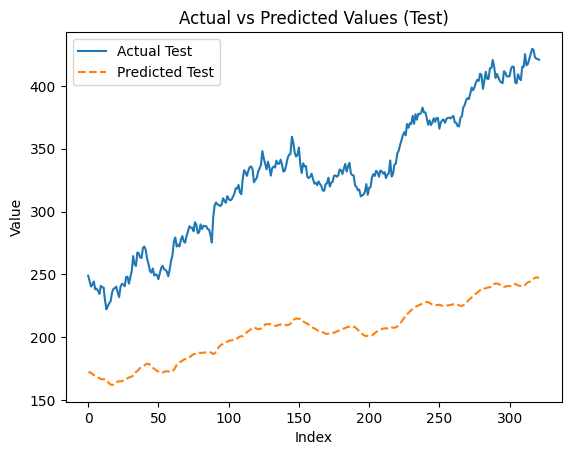

Running experiment: Model Type - GRU, Optimizer - SGD, Batch Size - 32, Learning Rate - 0.01, Sequence Length - 60
Training...


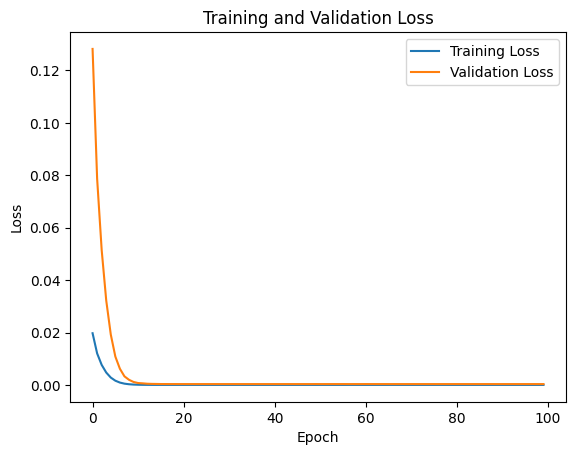

11/11 [==============================] - 0s 11ms/step


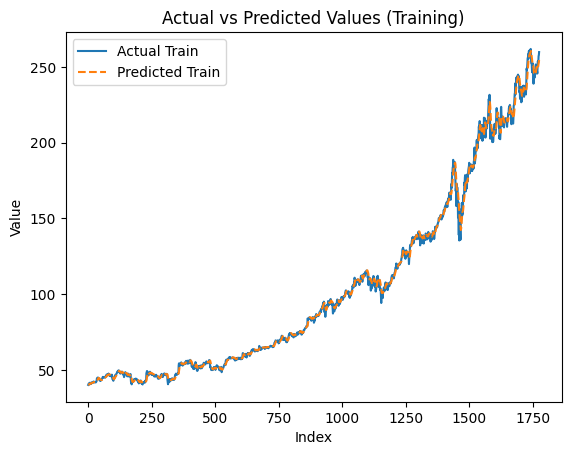

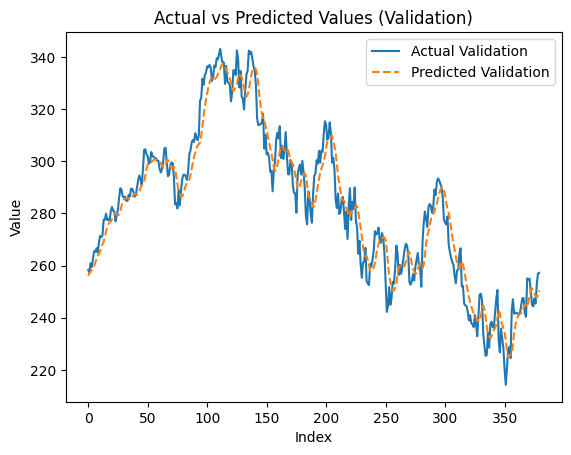

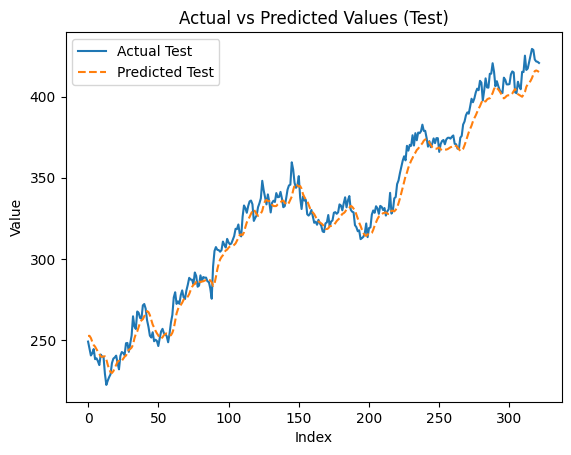

Running experiment: Model Type - GRU, Optimizer - SGD, Batch Size - 32, Learning Rate - 0.001, Sequence Length - 90
Training...


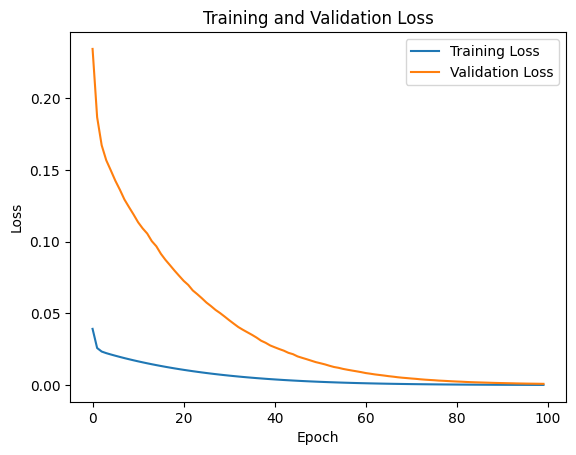

10/10 [==============================] - 0s 15ms/step


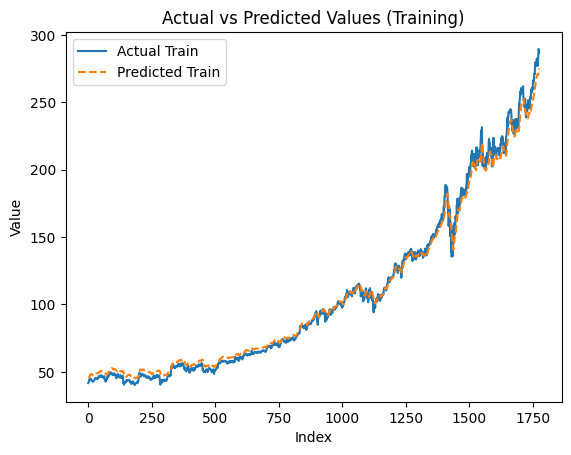

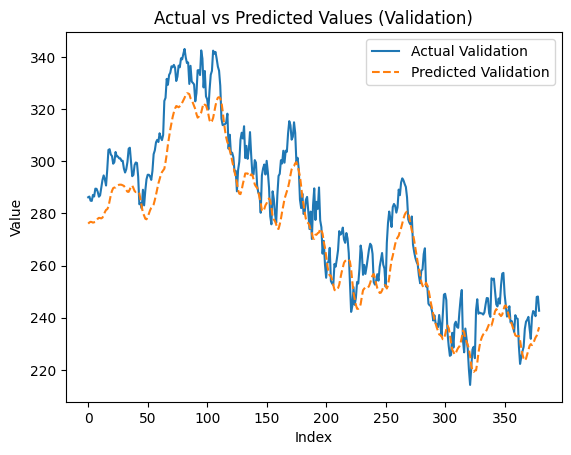

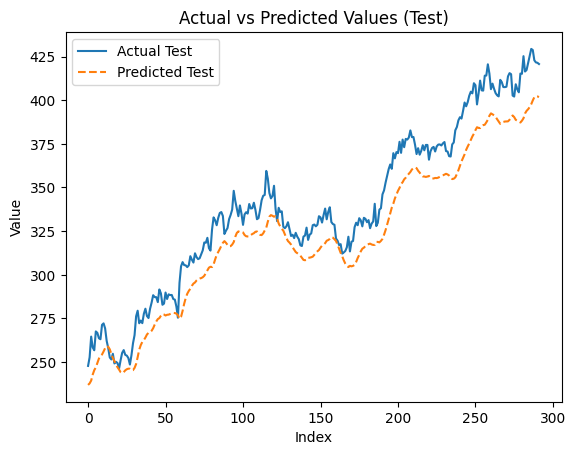

Model Type	Optimizer	Batch Size	Learning Rate	Sequence Length	# Parameters	Train RMSE	Validation RMSE	Test RMSE
LSTM	Adam	32	0.001	60	31901	2.309056626685181	5.7119960627499875	5.897861939295451
LSTM	Adam	64	0.001	60	31901	2.485812274289639	6.48323707168328	6.931446729235563
LSTM	Adam	32	0.01	60	31901	4.430084524034029	5.764910166390017	5.382478886255983
LSTM	Adam	32	0.001	90	31901	3.149370674115607	7.3367231563581115	5.843971032639518
LSTM	SGD	32	0.001	60	31901	5.047038730117537	14.581964213787229	24.932481473947266
LSTM	SGD	64	0.001	60	31901	20.826773451112906	65.4964353671491	92.93790615251989
LSTM	SGD	32	0.01	60	31901	4.4382665832781205	15.443655515422844	32.352965109209826
LSTM	SGD	32	0.001	90	31901	5.167013428211334	16.14932548475818	35.062590285681374
GRU	Adam	32	0.001	60	24551	2.5386908307152725	6.372016380024271	5.455265800982076
GRU	Adam	64	0.001	60	24551	3.6812625495189217	7.68271637763003	6.677186712692373
GRU	Adam	32	0.01	60	24551	2.379148275991883	6.412043301492128	15.969

In [83]:
results = []

# Experiment configurations

experiments = [
    ('LSTM', 'Adam', 32, 0.001, 60),
    ('LSTM', 'Adam', 64, 0.001, 60),
    ('LSTM', 'Adam', 32, 0.01, 60),
    ('LSTM', 'Adam', 32, 0.001, 90),
    ('LSTM', 'SGD', 32, 0.001, 60),
    ('LSTM', 'SGD', 64, 0.001, 60),
    ('LSTM', 'SGD', 32, 0.01, 60),
    ('LSTM', 'SGD', 32, 0.001, 90),
    ('GRU', 'Adam', 32, 0.001, 60),
    ('GRU', 'Adam', 64, 0.001, 60),
    ('GRU', 'Adam', 32, 0.01, 60),
    ('GRU', 'Adam', 32, 0.001, 90),
    ('GRU', 'SGD', 32, 0.001, 60),
    ('GRU', 'SGD', 64, 0.001, 60),
    ('GRU', 'SGD', 32, 0.01, 60),
    ('GRU', 'SGD', 32, 0.001, 90)
]

# Running experiments
results = []
for experiment in experiments:
    model_type, optimizer, batch_size, learning_rate, sequence_length = experiment
    print(f"Running experiment: Model Type - {model_type}, Optimizer - {optimizer}, Batch Size - {batch_size}, Learning Rate - {learning_rate}, Sequence Length - {sequence_length}")

    # Create sequences for the current sequence length
    X, y = create_sequences(scaled_data, sequence_length)

    # Split data into train, validation, and test sets
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + validation_size], y[train_size:train_size + validation_size]
    X_test, y_test = X[train_size + validation_size:], y[train_size + validation_size:]

    # Train and evaluate the model for the current configuration
    num_params, train_rmse, val_rmse, test_rmse = train_and_evaluate(optimizer=optimizer, learning_rate=learning_rate, batch_size=batch_size, sequence_length=sequence_length, model_type=model_type, num_epochs=100)
    
    
    # Append the results for the current experiment to the results list
    results.append((model_type, optimizer, batch_size, learning_rate, sequence_length, num_params, train_rmse, val_rmse, test_rmse))

# Displaying results
print("Model Type\tOptimizer\tBatch Size\tLearning Rate\tSequence Length\t# Parameters\tTrain RMSE\tValidation RMSE\tTest RMSE")
for result in results:
    print("\t".join([str(elem) for elem in result]))



---
## Conclusions

| Model Type | Optimizer | Batch Size | Learning Rate | Sequence Length | # Parameters | Train RMSE | Validation RMSE | Test RMSE |
|------------|-----------|------------|---------------|-----------------|--------------|------------|-----------------|-----------|
| BASELINE   | -         | -          | -             | -               | -            | 2.25       | 5.28            | 4.79      |
| LSTM       | Adam      | 32         | 0.001         | 60              | 31901        | 2.31       | 5.71            | 5.90      |
| LSTM       | Adam      | 64         | 0.001         | 60              | 31901        | 2.49       | 6.48            | 6.93      |
| LSTM       | Adam      | 32         | 0.01          | 60              | 31901        | 4.43       | 5.76            | 5.38      |
| LSTM       | Adam      | 32         | 0.001         | 90              | 31901        | 3.15       | 7.34            | 5.84      |
| LSTM       | SGD       | 32         | 0.001         | 60              | 31901        | 5.05       | 14.58           | 24.93     |
| LSTM       | SGD       | 64         | 0.001         | 60              | 31901        | 20.83      | 65.50           | 92.94     |
| LSTM       | SGD       | 32         | 0.01          | 60              | 31901        | 4.44       | 15.44           | 32.35     |
| LSTM       | SGD       | 32         | 0.001         | 90              | 31901        | 5.17       | 16.15           | 35.06     |
| GRU        | Adam      | 32         | 0.001         | 60              | 24551        | 2.54       | 6.37            | 5.46      |
| GRU        | Adam      | 64         | 0.001         | 60              | 24551        | 3.68       | 7.68            | 6.68      |
| GRU        | Adam      | 32         | 0.01          | 60              | 24551        | 2.38       | 6.41            | 15.97     |
| GRU        | Adam      | 32         | 0.001         | 90              | 24551        | 2.77       | 6.35            | 5.18      |
| GRU        | SGD       | 32         | 0.001         | 60              | 24551        | 13.05      | 37.69           | 50.47     |
| GRU        | SGD       | 64         | 0.001         | 60              | 24551        | 33.68      | 98.16           | 127.05    |
| GRU        | SGD       | 32         | 0.01          | 60              | 24551        | 2.83       | 7.54            | 8.19      |
| GRU        | SGD       | 32         | 0.001         | 90              | 24551        | 4.82       | 11.82           | 17.50     |



From the table we can draw several conclusions:  

**Baseline Performance**: None of the models were able to beat the base model.  

**Optimizers Impact**: The choice of optimizer significantly affects model performance. Models trained with the `Adam` optimizer performed better compared to those trained with `SGD`.  

**Batch Size Influence**: Across all the experiments `small (32)`  batch sizes performed better than `large (64)` batch sizes, holding everything else constant.  

**Learning Rate Sensitivity**: The learning rate also plays a crucial role. A smaller `learning rate of 0.001` yielded better results across all the experiments.  

**Sequence Length Effect**: Models trained with a `longer sequence length (90)` had higher error rates compared to those trained with `shorter sequence lengths (60)`, suggesting that longer historical data sequences might not always improve prediction accuracy.  

**Model Comparison**: The performance between `LSTM` and `GRU` models is comparable, with slight variations depending on the optimizer, batch size, learning rate, and sequence length. The `LSTM` models on avarage performed slightly better.  

**Overfitting**: There are signs of overfitting, especially noticeable in models with significantly lower training RMSE compared to validation and test RMSE. This suggests that these models might be fitting too closely to the training data and performing poorly on unseen data.  

**Recommendations**: Based on the results, it seems that models trained with the `Adam optimizer` and a `learning rate of 0.001` generally perform better. Additionally, careful consideration should be given to batch size and sequence length.  


In summary, while LSTM and GRU models show promise for stock price prediction, further optimization and fine-tuning of hyperparameters are necessary to enhance predictive accuracy.  

Additionally, it would be beneficial to explore other features to enhance the models, such as including external indexes, company specific metrics, and macroeconomic variables.


## Contributions

All the team members contributed equally to this project. Data selection, processing, model selection, algorithm implementations and slides were all produced as a group with equal participation.